In [1]:
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

In [2]:
import restaurants_timeseries.core as core
import restaurants_timeseries.surveyors as surveyors

import GPy
import plotnine as pn
import pandas as pd
import numpy as np
from typing import List
from mizani.formatters import date_format
from fastcore.foundation import patch
import warnings

Input is multiple stores.


In [3]:
pn.options.figure_size = figure_size=(15, 4)
RESPONSE = 'visitors'
VAL_DAYS = 45 * 2
DAYS_IN_WEEK = 7


def default_date_scale():
    return [pn.scale_x_date(breaks="1 week", labels=date_format("%b %d '%y"))]


def plot_single_timeseries(dat: pd.DataFrame):
    return (
        pn.ggplot(dat, pn.aes('visit_date', 'visitors', color='dataset')) +
        pn.geom_line(pn.aes(group='air_store_id')) +
        pn.theme_bw() +
        pn.theme(axis_text_x=pn.element_text(angle=90*3, size=9),
                 panel_grid=pn.element_blank(),
                 legend_position="top", legend_title=pn.element_blank()))


def make_predictions_frame(days: List[int], dates, means: List[float], 
                           variances: List[float]) -> pd.DataFrame:
    pred_dat = pd.DataFrame({'day': days, 'visit_date': dates, 'mean': means, 
                             'var': variances, 'sd': np.sqrt(variances)})
    pred_dat.loc[:, 'mean'] = np.maximum(0.0, pred_dat['mean'])
    pred_dat.loc[:, 'lower_bound'] = np.maximum(0.0, pred_dat['mean'] - 2 * pred_dat['sd'])
    pred_dat.loc[:, 'upper_bound'] = np.maximum(0.0, pred_dat['mean'] + 2 * pred_dat['sd'])
    return pred_dat


def _predict_and_enframe_subset(
        X: np.ndarray, dates_df: pd.DataFrame, model) -> pd.DataFrame:
    p = model.predict(X)
    means = [x[0] for x in p[0]]
    variances = [x[0] for x in p[1]]
    pred_dat = make_predictions_frame(days=dates_df['day'], dates=dates_df['visit_date'],
                                      means=means, variances=variances)
    pred_dat['Prediction'] = 'Prediction'
    return pred_dat


class Set:
    def __init__(self, dat, predictors: List[str], response: str = RESPONSE):
        self.data = dat.copy()
        self.X = dat[predictors].to_numpy()
        self.y = dat[[response]].to_numpy()


@patch
def split_datasets(self: surveyors.VisitsSurveyor, val_days: int, predictors: List[str]):
    """
    Splits self.visits into Training and Validation sets, setting the fields `trn` and `val`.
    Also adds the column `dataset` to self.visits.
    """
    self.predictors = predictors
    if len(self.visits['air_store_id'].unique()) > 1:
        raise ValueError(
            "This class only supports a dataframe of a single 'air_store_id' right now.")
    earliest = surveyors.get_earliest_date(self.visits)
    latest = surveyors.get_latest_date(self.visits)
    self.visits['dataset'] = ['Training' if (latest - visit_date).days >= val_days else 'Validation'
                              for visit_date in self.visits['visit_date']]
    self.visits['group'] = 'group' # for plotnine line connections
    split_counts = dict(self.visits.groupby('dataset').count()['air_store_id'])    
    if split_counts['Validation'] != val_days:
        warnings.warn(f"Expected to find {val_days} days in the validation set, " +
                      f"but found {split_counts['Validation']} instead.")
    if split_counts['Training'] < split_counts['Validation']:
        warnings.warn(f"Less training days than validation days: {split_counts}.")
    assert self.visits['dataset'].count()    
    
    self.trn = Set(self.visits.query("dataset == 'Training'"), predictors)
    self.val = Set(self.visits.query("dataset == 'Validation'"), predictors)


@patch
def _predict_and_enframe_trn(self: surveyors.VisitsSurveyor, X, model):
    pred_dat = _predict_and_enframe_subset(X, self.trn.data, model)
    pred_dat['visit_date'] = self.trn.data['visit_date']
    for predictor in self.predictors:
        pred_dat[predictor] = self.trn.data[predictor]
    pred_dat['dataset'] = 'Training'
    return pred_dat


@patch
def _predict_and_enframe_val(self: surveyors.VisitsSurveyor, X, model):
    pred_dat = _predict_and_enframe_subset(X, self.val.data, model)
    for predictor in self.predictors:
        pred_dat[predictor] = self.val.data[predictor]
    pred_dat['dataset'] = 'Validation'
    return pred_dat

@patch
def predict_and_enframe(self: surveyors.VisitsSurveyor, model):
    trn_pred_dat = self._predict_and_enframe_trn(self.trn.X, model)
    val_pred_dat = self._predict_and_enframe_val(self.val.X, model)
    pred_dat = pd.concat([trn_pred_dat, val_pred_dat])
    pred_dat['group'] = 'group'
    return pred_dat


@patch
def prepare_variables(self: surveyors.VisitsSurveyor) -> List[str]:
    self.visits['day_of_week'] = np.mod(self.visits['day'], DAYS_IN_WEEK)
    self.visits['day_of_month'] = self.visits['visit_date'].apply(lambda d: d.day)
    self.visits['day_of_year'] = self.visits['visit_date'].apply(lambda d: d.dayofyear)
    return ['day', 'day_of_week', 'day_of_month', 'holiday_flg']

In [4]:
MOST_OPEN_IND = 3
target_id = surveyors.most_open_stores[MOST_OPEN_IND]
single_store_visits: pd.DataFrame = (
    core.data['visits']
    .query(f"air_store_id == '{target_id}'")
    .copy())
single_store_reservations: pd.DataFrame = (
    core.data['reservations']
    .query(f"air_store_id == '{target_id}'")
    .copy())

In [5]:
vs = surveyors.VisitsSurveyor(single_store_visits, False)
rs = surveyors.ReservationsSurveyor(single_store_reservations)


Input is a single store.


In [6]:
predictors = vs.prepare_variables()
vs.split_datasets(VAL_DAYS, predictors=predictors)


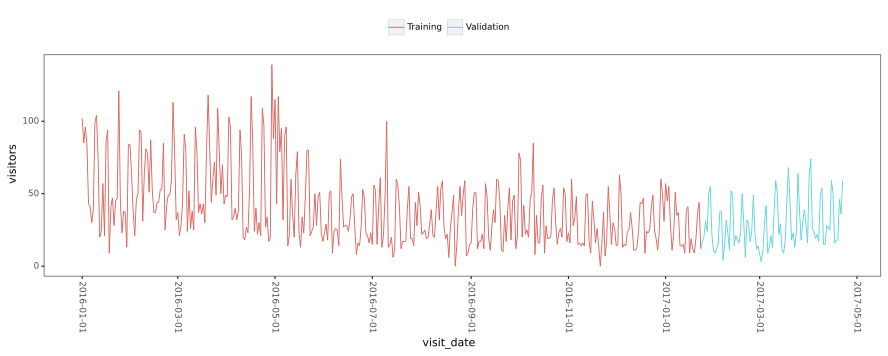

<ggplot: (8550236328150)>

In [7]:
plot_single_timeseries(vs.visits)

In [8]:
base_kernel = GPy.kern.RBF(input_dim=vs.trn.X.shape[1], variance=1, lengthscale=3.0)
periodic_kernel = GPy.kern.StdPeriodic(input_dim=1, variance=1, period=7.0, ARD1=False)

kernel = base_kernel + periodic_kernel
#kernel = base_kernel
#kernel = periodic_kernel

In [9]:
model = GPy.models.GPRegression(vs.trn.X, vs.trn.y, kernel)
# model.plot()

In [10]:
pred_dat = vs.predict_and_enframe(model)

In [11]:
pred_dat

,day,visit_date,mean,var,sd,lower_bound,upper_bound,Prediction,day_of_week,day_of_month,holiday_flg,dataset,group
212487,0,2016-01-01,69.415034,1.390255,1.179091,67.056852,71.773215,Prediction,0,1,1,Training,group
212488,1,2016-01-02,94.430485,1.300180,1.140254,92.149977,96.710994,Prediction,1,2,1,Training,group
212489,2,2016-01-03,90.870639,1.304440,1.142121,88.586398,93.154881,Prediction,2,3,1,Training,group
212490,3,2016-01-04,60.636198,1.304304,1.142061,58.352075,62.920321,Prediction,3,4,0,Training,group
212491,4,2016-01-05,44.657768,1.292004,1.136663,42.384441,46.931094,Prediction,4,5,0,Training,group
...,...,...,...,...,...,...,...,...,...,...,...,...,...
212960,473,2017-04-18,24.692474,2.028449,1.424236,21.844001,27.540947,Prediction,4,18,0,Validation,group
212961,474,2017-04-19,29.162088,2.029138,1.424478,26.313132,32.011044,Prediction,5,19,0,Validation,group
212962,475,2017-04-20,28.025802,2.024202,1.422745,25.180312,30.871291,Prediction,6,20,0,Validation,group
212963,476,2017-04-21,37.395270,2.024071,1.422699,34.549873,40.240667,Prediction,0,21,0,Validation,group


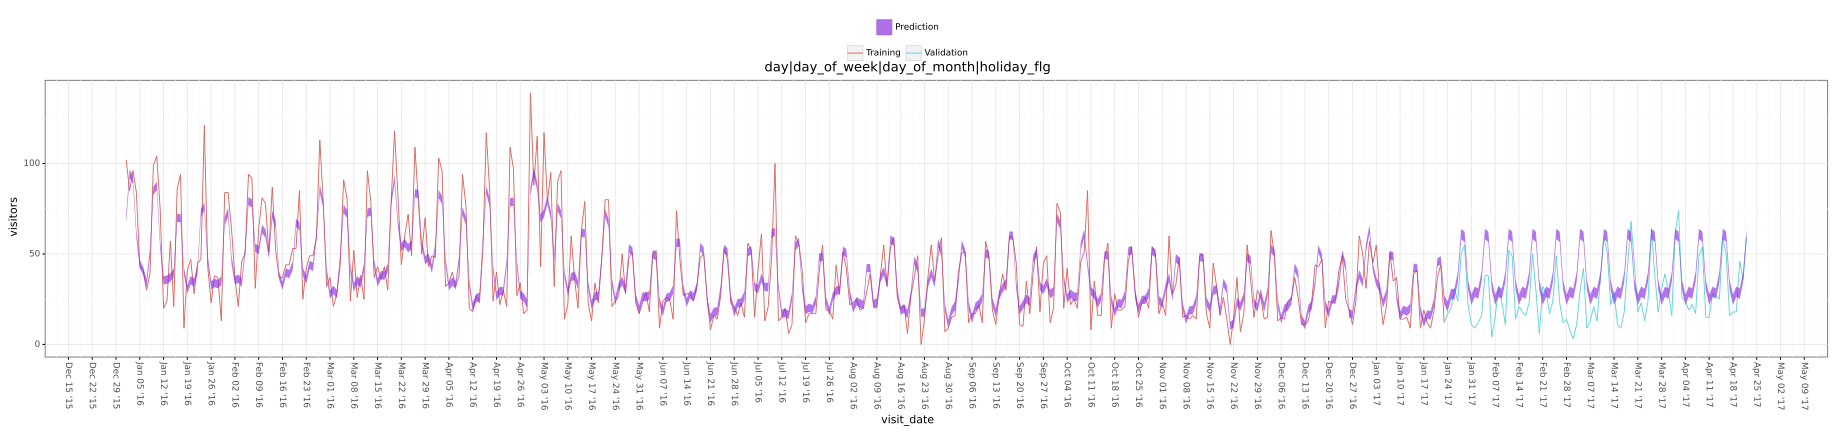

<ggplot: (8550235672592)>

In [12]:
prediction_plot = (
    pn.ggplot(pn.aes(x='visit_date')) +
    pn.geom_line(data=vs.visits, mapping=pn.aes(y='visitors', color='dataset', group='group')) +
    pn.geom_ribbon(data=pred_dat, mapping=pn.aes(ymax='upper_bound', ymin='lower_bound', fill='Prediction'), 
                   alpha=0.65) +
    pn.scale_fill_manual(values = ["#8A2BE2"]) +
    default_date_scale() +
    pn.ggtitle("|".join(vs.predictors)) +
    pn.theme_bw() +    
    pn.theme(legend_title=pn.element_blank(),
             legend_position="top",
             figure_size=(32, 5), 
             axis_text_x=pn.element_text(angle=270)))

display(prediction_plot)

In [13]:
prediction_plot.save(
    filename=f'predictions_valdays{VAL_DAYS}_{target_id}.png', format='png', path='intermediate', 
    width=30, height=6, units='in', dpi=220, limitsize=False)

 /opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning:Saving 30 x 6 in image.
 /opt/conda/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning:Filename: intermediate/predictions_valdays90_air_d97dabf7aae60da5.png
